## Ensamble model for classifying endangered languages

**Summary**

The notebook focuses on building and evaluating ensemble models for classifying endangered languages based on various features. It includes steps for data loading, feature preparation with engineering, handling class imbalance, training different ensemble models (Voting and Bagging), and tuning their hyperparameters.

Model Tests Conducted:

1. Base Ensemble Model (Voting Classifier):

2. Tuned Ensemble Model (Voting Classifier):

3. Bagging Classifier Model:

Data Modification:
- Created a modified dataframe (df_modified) by combining 'Severely Endangered' and 'Critically Endangered' into 'Highly Endangered'.
Further modified df_modified to combine 'Threatened' and 'Vulnerable' into 'At Risk'.
Trained and evaluated the models on this df_modified with the combined classes.

Training models on the data with combined classes (level_combined) consistently resulted in higher test accuracies compared to training on the original granular levels (level). Among the models tested on the combined classes, the Bagging Classifier with hyperparameter tuning and SMOTE achieved the highest test accuracy of 0.885, however the tuned ensamble voting classifier model experienced less overfitting to the training data. This suggests that both combining classes and using ensemble methods with appropriate imbalance handling are beneficial for this classification task.

In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import (train_test_split, cross_val_score, StratifiedKFold,
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                             ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier,
                              BaggingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

import matplotlib.pyplot as plt
import seaborn as sns

import warnings


In [23]:
# load and inspect the final_dataset
df = pd.read_parquet('Data Cleaning/final_dataset2.parquet')

In [24]:
comma_separated_names = ','.join(df['official_name'].astype(str))

# Write to file
with open('official_names.txt', 'w') as file:
    file.write(comma_separated_names)

In [25]:
def prepare_features_with_engineering(df):
    """
    Prepare features with additional feature engineering
    """
    # Create copy to avoid modifying original
    df_feat = df.copy()

    # Ensure numeric columns are properly typed
    numeric_cols = ['speakers', 'official', 'regional', 'minority', 'national',
                   'widely_spoken', 'country_count', 'max_urbanization',
                   'max_internet_use']

    for col in numeric_cols:
        if col in df_feat.columns:
            df_feat[col] = pd.to_numeric(df_feat[col], errors='coerce').fillna(0)
            # Do we want to keep this as zero or use an identifier number like -1?

    # Add ratio features
    df_feat['urbanization_internet_product'] = df_feat['max_urbanization'] * df_feat['max_internet_use']
    df_feat['official_national_sum'] = df_feat['official'] + df_feat['national']
    df_feat['minority_regional_sum'] = df_feat['minority'] + df_feat['regional']

    # Log transform skewed features
    df_feat['log_speakers'] = np.log1p(df_feat['speakers'])

    # Interaction features
    df_feat['speakers_urbanization'] = df_feat['speakers'] * df_feat['max_urbanization']
    df_feat['speakers_internet'] = df_feat['speakers'] * df_feat['max_internet_use']

    # Replace any infinities or NaNs
    df_feat = df_feat.replace([np.inf, -np.inf], 0)
    df_feat = df_feat.fillna(0)
    # Again, do we want to just fill with 0, which could change the model output, or fill with something like -1?

    return df_feat

In [26]:
def handle_class_imbalance(X_train, y_train, method='class_weight'):
    """
    Handle class imbalance using available methods
    """
    try:
        from imblearn.over_sampling import SMOTE, ADASYN
        from imblearn.combine import SMOTETomek
        HAS_IMBALANCED_LEARN = True
    except ImportError:
        HAS_IMBALANCED_LEARN = False
        print("imbalanced-learn not available. Install with: pip install imbalanced-learn")

    if HAS_IMBALANCED_LEARN and method == 'smote':
        smote = SMOTE(random_state=42, k_neighbors=min(5, min(np.bincount(y_train)) - 1))
        return smote.fit_resample(X_train, y_train)
    else:
        # Return original data if SMOTE not available
        return X_train, y_train

In [27]:
# Create a new column with combined classes
df_modified = df.copy()

def combine_endangered_classes(level):
    if level in ['Severely Endangered', 'Critically Endangered']:
        return 'Highly Endangered'
    elif level in ['Threatened', 'Vulnerable', 'At risk']:
        return 'At Risk'
    else:
        return level

df_modified['level_combined'] = df_modified['level'].apply(combine_endangered_classes)

## Base Ensamble Model (no tuning)

Granular levels
- Training Accuracy: 93.3%
- Validation Accuracy: 73.2%
- Test Accuracy: 76.8%
- *Notes:* Large gap between training and validation/test accuracies indicates overfitting.


Grouped levels
- Training Accuracy: 95.6%
- Validation Accuracy: 89.0%
- Test Accuracy: 88.2%
- *Notes:* Improvements in both validation and test accuracy, but the gap indicating overfitting is still ~7%.

In [28]:
def train_ensemble_model(df_input, target_column='level'):
    """
    Train an ensemble of the best available models using a specified target column.

    Args:
        df_input (pd.DataFrame): The input dataframe (either original or modified).
        target_column (str): The name of the target column ('level' or 'level_combined').
    """
    print(f"\nTraining Ensemble Model (Target: {target_column})...")

    # Prepare features
    df_feat = prepare_features_with_engineering(df_input)

    # Select features
    feature_cols = list(df_input.columns[4:12]) + [
        'urbanization_internet_product',
        'official_national_sum', 'minority_regional_sum',
        'log_speakers', 'speakers_urbanization', 'speakers_internet'
    ]

    X = df_feat[feature_cols]
    # Use the specified target column
    y = df_feat[target_column]

    # Encode target variable 'y' into numeric labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)


    # Split into train (80) and test (20)
    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
        X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )

    # Then split train into train (60) and val (20)
    X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(
        X_train, y_train_encoded, test_size=0.25, stratify=y_train_encoded, random_state=42
    )

    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    # Handle class imbalance
    # Ensure k_neighbors is set based on the smallest class size if needed
    min_samples = min(np.bincount(y_train_encoded))
    n_neighbors_smote = max(1, min(5, min_samples - 1))

    X_train_balanced, y_train_balanced = handle_class_imbalance(X_train_scaled, y_train_encoded, method='smote') # Use encoded labels


    # Create base models
    estimators = []

    # Always include these
    estimators.append(('gb', GradientBoostingClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42
    )))

    estimators.append(('et', ExtraTreesClassifier(
        n_estimators=100, max_depth=10, class_weight='balanced', random_state=42
    )))

    estimators.append(('rf', RandomForestClassifier(
        n_estimators=100, max_depth=10, class_weight='balanced', random_state=42
    )))

    # Create ensemble
    ensemble = VotingClassifier(estimators=estimators, voting='soft')

    # Train ensemble
    ensemble.fit(X_train_balanced, y_train_balanced)

    # Predictions
    y_train_pred_encoded = ensemble.predict(X_train_balanced)
    y_val_pred_encoded = ensemble.predict(X_val_scaled)
    y_test_pred_encoded = ensemble.predict(X_test_scaled)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train_balanced, y_train_pred_encoded)
    val_accuracy = accuracy_score(y_val_encoded, y_val_pred_encoded)
    test_accuracy = accuracy_score(y_test_encoded, y_test_pred_encoded)

    print(f"Training Accuracy: {train_accuracy:.3f}")
    print(f"Validation Accuracy: {val_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")

    # Decode predictions back to original labels for classification report and confusion matrix
    y_pred = le.inverse_transform(y_test_pred_encoded)
    y_val_pred = le.inverse_transform(y_val_pred_encoded)


    print(f"\nValidation Classification Report (Target: {target_column}):")
    print(classification_report(le.inverse_transform(y_val_encoded), y_val_pred))
    print(f"\nTest Classification Report (Target: {target_column}):")
    print(classification_report(le.inverse_transform(y_test_encoded), y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(le.inverse_transform(y_test_encoded), y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f'Ensemble Model Confusion Matrix (Target: {target_column})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Return original y_train and y_test for potential further use outside the function
    return ensemble, scaler, feature_cols, X_train, X_test, y_train_encoded, y_test_encoded


Training Ensemble Model (Target: level)...
Training Accuracy: 0.933
Validation Accuracy: 0.732
Test Accuracy: 0.768

Validation Classification Report (Target: level):
                       precision    recall  f1-score   support

              At risk       0.53      0.69      0.60        13
Critically Endangered       0.82      0.65      0.72        77
           Endangered       0.74      0.74      0.74       130
              Extinct       0.97      0.97      0.97        35
       Not Endangered       1.00      1.00      1.00        18
  Severely Endangered       0.53      0.45      0.48        67
           Threatened       0.71      0.88      0.79       149
           Vulnerable       0.72      0.61      0.66        85

             accuracy                           0.73       574
            macro avg       0.75      0.75      0.75       574
         weighted avg       0.73      0.73      0.73       574


Test Classification Report (Target: level):
                       preci

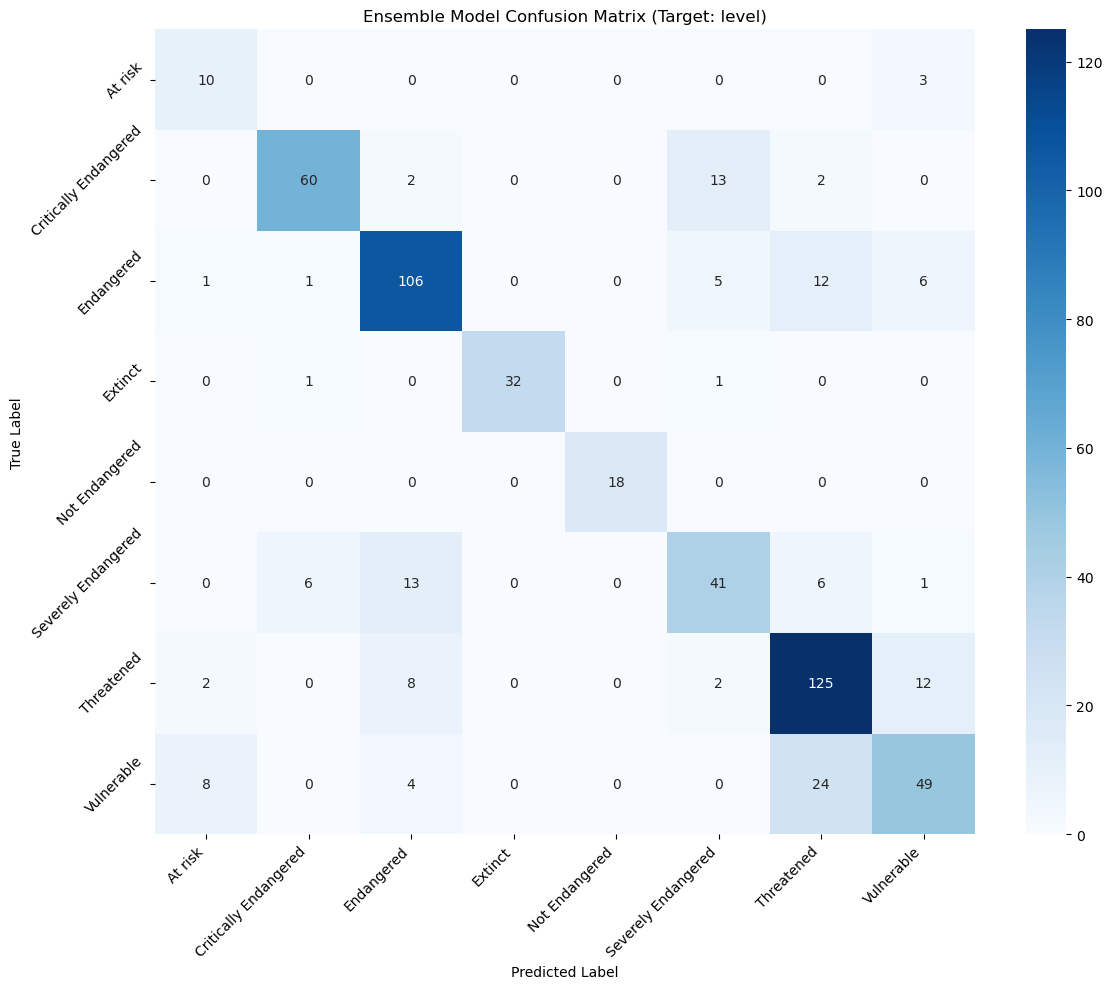

In [29]:
ensemble_model, scaler, features, X_train, X_test, y_train_encoded, y_test_encoded = train_ensemble_model(df, target_column='level')


Training Ensemble Model (Target: level_combined)...
Training Accuracy: 0.956
Validation Accuracy: 0.890
Test Accuracy: 0.882

Validation Classification Report (Target: level_combined):
                   precision    recall  f1-score   support

          At Risk       0.89      0.94      0.91       247
       Endangered       0.83      0.73      0.78       131
          Extinct       1.00      0.97      0.99        34
Highly Endangered       0.90      0.92      0.91       144
   Not Endangered       1.00      1.00      1.00        18

         accuracy                           0.89       574
        macro avg       0.92      0.91      0.92       574
     weighted avg       0.89      0.89      0.89       574


Test Classification Report (Target: level_combined):
                   precision    recall  f1-score   support

          At Risk       0.88      0.95      0.91       247
       Endangered       0.82      0.75      0.78       131
          Extinct       1.00      0.97      0.99

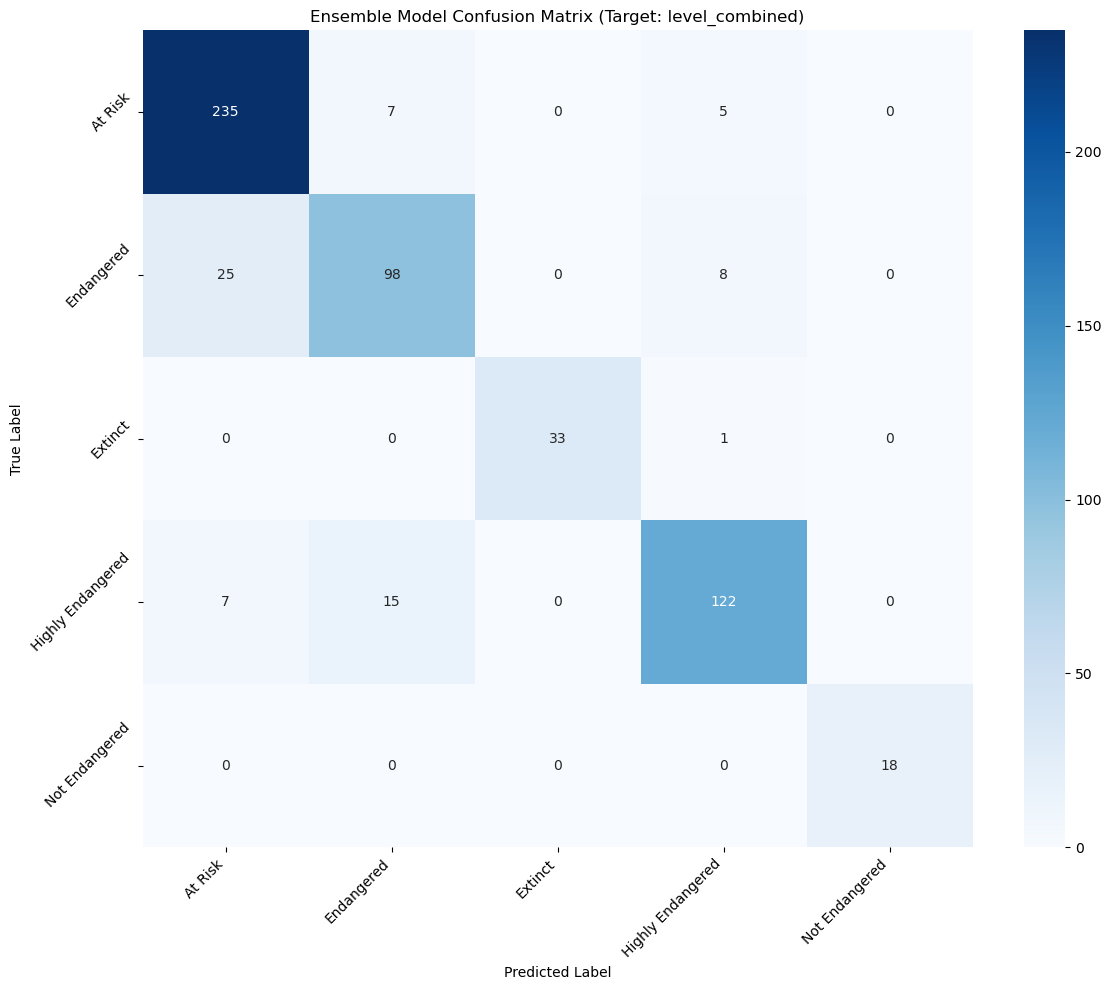

In [30]:
ensemble_model, scaler, features, X_train, X_test, y_train_encoded, y_test_encoded = train_ensemble_model(df_modified, target_column='level_combined')

## Tuning: Ensamble with Voting Method

| Configuration | Features Used | Class Imbalance Handling | Voting | Test Accuracy | Precision (Macro Avg) | Recall (Macro Avg) | F1-Score (Macro Avg) | Notes |
|---|---|---|---|---|---|---|---|---|
| Baseline | Original Features | None | Soft | 36.1% | 32% | 34% | 32% |  |
| Config 1 | Original + Engineered Features | None | Soft | 76% | 78% | 78% | 78% |  |
| Config 2 | Original + Engineered Features |None | Soft | 75.3% | 76% | 75% | 75% | Included validation set |
| Config 3 | Original + Engineered Features |None | Hard | 77.4% | 78% | 78% | 78% | Set voting to hard |
| Config 4 | Original + Engineered Features |SMOTE | Hard | 77% | 78% | 79% | 78% | Handle class imbalance |
| Config 5 | Original + Engineered Features |SMOTE | Hard | 76.5% | 78% | 78% | 77% | Add XGBOOST and LIGHTGBM |
| Config 6 | Original + Engineered Features |SMOTE | Soft | 76.5% | 78% | 79% | 78% | Change to soft voting |
| Config 7 | Original + Engineered Features |SMOTE | Soft | 74.9% | 77% | 79% | 77% | Remove XGBOOST and LIGHTGBM, add SVC to ensamble, add tuner tests to all models |

### Best voting models

Granular levels (config 3)
- Training Accuracy: 82.4%
- Validation Accuracy: 74.6%
- Test Accuracy: 76.1%
- *Notes:* Reduced training accuracy, reduced overfitting gap (~6%), no improvement in test accuracy

Grouped levels (config 3 with grouped levels)
- Training Accuracy: 91.1%
- Validation Accuracy: 88.9%
- Test Accuracy: 88.3%
- *Notes:* Almost the same accuracies as the base grouped level model, but with less overfitting to the training data (~3% gap).


In [31]:
def tune_hyperparameters(df_input, target_column='level'):
    """
    Tune hyperparameters for the ensemble models using GridSearchCV or RandomizedSearchCV,
    using a specified target column.
    Refined for Config 3: Original + Engineered Features, No Class Imbalance Handling, Hard Voting (GB, ET, RF).

    Args:
        df_input (pd.DataFrame): The input dataframe (either original or modified).
        target_column (str): The name of the target column ('level' or 'level_combined').
    """
    print(f"\nTuning Hyperparameters for Config 3 (Target: {target_column})...")

    # Prepare features
    df_feat = prepare_features_with_engineering(df_input)

    # Select features (same as in the training function)
    feature_cols = list(df_input.columns[4:12]) + [
        'urbanization_internet_product',
        'official_national_sum', 'minority_regional_sum',
        'log_speakers', 'speakers_urbanization', 'speakers_internet'
    ]

    X = df_feat[feature_cols]
    # Use the specified target column
    y = df_feat[target_column]

    # Encode target variable 'y' into numerical labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split into train (80) and test (20)
    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
        X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )

    # Then split train into train (60) and val (20)
    X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(
        X_train, y_train_encoded, test_size=0.25, stratify=y_train_encoded, random_state=42
    )


    # Scale features - apply scaler to train, val, and test sets
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    # No Class Imbalance Handling for Config 3
    X_train_balanced = X_train_scaled # Use scaled data directly
    y_train_balanced = y_train_encoded # Use encoded labels directly


    # Define parameter grids for base models
    gb_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.5],
    }

    et_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15],
        'class_weight': ['balanced', None], # Keep class_weight for potential benefit even without SMOTE
    }

    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15],
        'class_weight': ['balanced', None], # Keep class_weight for potential benefit even without SMOTE
    }


    # Tune Gradient Boosting
    print("\nTuning Gradient Boosting...")
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    gb_grid_search.fit(X_train_balanced, y_train_balanced)
    print(f"Best GB parameters: {gb_grid_search.best_params_}")
    best_gb_model = gb_grid_search.best_estimator_

    # Tune Extra Trees
    print("\nTuning Extra Trees...")
    et_model = ExtraTreesClassifier(random_state=42)
    et_grid_search = GridSearchCV(et_model, et_param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    et_grid_search.fit(X_train_balanced, y_train_balanced)
    print(f"Best ET parameters: {et_grid_search.best_params_}")
    best_et_model = et_grid_search.best_estimator_

    # Tune Random Forest
    print("\nTuning Random Forest...")
    rf_model = RandomForestClassifier(random_state=42)
    rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    rf_grid_search.fit(X_train_balanced, y_train_balanced)
    print(f"Best RF parameters: {rf_grid_search.best_params_}")
    best_rf_model = rf_grid_search.best_estimator_


    # Use the best estimators in the VotingClassifier
    estimators = [
        ('gb', best_gb_model),
        ('et', best_et_model),
        ('rf', best_rf_model)
    ]

    # Create the final ensemble with tuned models and Hard Voting
    tuned_ensemble = VotingClassifier(estimators=estimators, voting='hard')

    # Train the final tuned ensemble on the entire training data
    tuned_ensemble.fit(X_train_balanced, y_train_balanced)

    print("\nTuned Ensemble Trained (Config 3).")

    # Evaluate the tuned ensemble on the training, validation, and test sets
    y_train_pred_encoded = tuned_ensemble.predict(X_train_balanced)
    y_val_pred_encoded = tuned_ensemble.predict(X_val_scaled)
    y_pred_encoded = tuned_ensemble.predict(X_test_scaled)

    train_accuracy = accuracy_score(y_train_balanced, y_train_pred_encoded)
    val_accuracy = accuracy_score(y_val_encoded, y_val_pred_encoded)
    accuracy = accuracy_score(y_test_encoded, y_pred_encoded)

    print(f"\nTraining Accuracy: {train_accuracy:.3f}")
    print(f"Validation Accuracy of Tuned Ensemble (Config 3, Target: {target_column}): {val_accuracy:.3f}")
    print(f"Test Accuracy of Tuned Ensemble (Config 3, Target: {target_column}): {accuracy:.3f}")


    # Decode predictions back to original labels for evaluation
    y_val_pred = le.inverse_transform(y_val_pred_encoded)
    y_pred = le.inverse_transform(y_pred_encoded)

    print(f"\nValidation Classification Report of Tuned Ensemble (Config 3, Target: {target_column}):")
    print(classification_report(le.inverse_transform(y_val_encoded), y_val_pred))
    print(f"\nTest Classification Report of Tuned Ensemble (Config 3, Target: {target_column}):")
    print(classification_report(le.inverse_transform(y_test_encoded), y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(le.inverse_transform(y_test_encoded), y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f'Tuned Ensemble Model Confusion Matrix (Config 3, Target: {target_column})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Return the encoded target variables
    return tuned_ensemble, scaler, feature_cols, X_train, X_test, y_train_encoded, y_test_encoded


Tuning Hyperparameters for Config 3 (Target: level)...

Tuning Gradient Boosting...
Best GB parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}

Tuning Extra Trees...
Best ET parameters: {'class_weight': None, 'max_depth': 15, 'n_estimators': 200}

Tuning Random Forest...
Best RF parameters: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200}

Tuned Ensemble Trained (Config 3).

Training Accuracy: 0.824
Validation Accuracy of Tuned Ensemble (Config 3, Target: level): 0.746
Test Accuracy of Tuned Ensemble (Config 3, Target: level): 0.761

Validation Classification Report of Tuned Ensemble (Config 3, Target: level):
                       precision    recall  f1-score   support

              At risk       0.56      0.38      0.45        13
Critically Endangered       0.84      0.64      0.73        77
           Endangered       0.75      0.73      0.74       130
              Extinct       0.97      0.97      0.97        35
       Not Endangered    

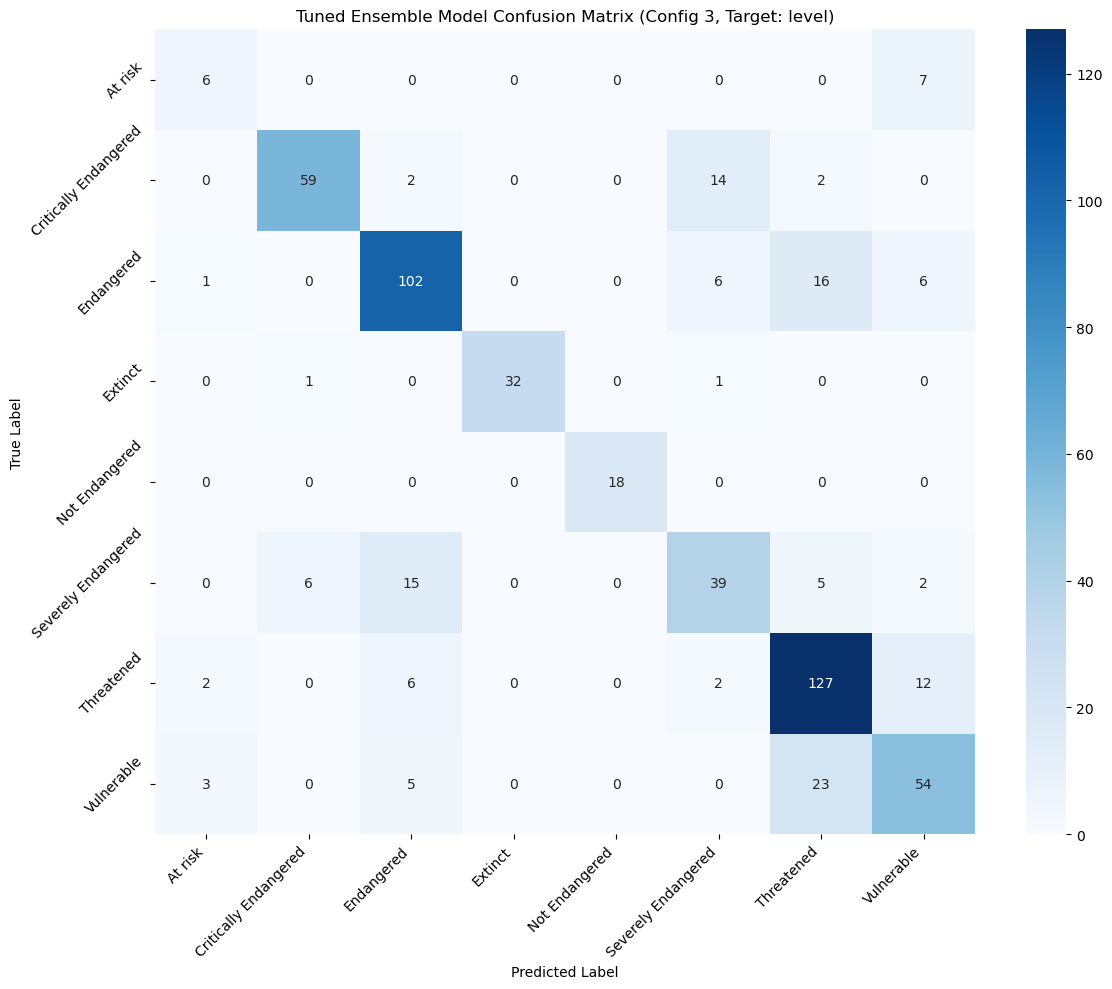

In [32]:
tuned_ensemble_model, scaler, feature_cols, X_train, X_test, y_train_encoded, y_test_encoded = tune_hyperparameters(df, target_column='level')


Tuning Hyperparameters for Config 3 (Target: level_combined)...

Tuning Gradient Boosting...
Best GB parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

Tuning Extra Trees...
Best ET parameters: {'class_weight': None, 'max_depth': 15, 'n_estimators': 100}

Tuning Random Forest...
Best RF parameters: {'class_weight': None, 'max_depth': 10, 'n_estimators': 200}

Tuned Ensemble Trained (Config 3).

Training Accuracy: 0.911
Validation Accuracy of Tuned Ensemble (Config 3, Target: level_combined): 0.889
Test Accuracy of Tuned Ensemble (Config 3, Target: level_combined): 0.883

Validation Classification Report of Tuned Ensemble (Config 3, Target: level_combined):
                   precision    recall  f1-score   support

          At Risk       0.88      0.94      0.91       247
       Endangered       0.84      0.73      0.78       131
          Extinct       1.00      0.97      0.99        34
Highly Endangered       0.90      0.92      0.91       144
   Not Endanger

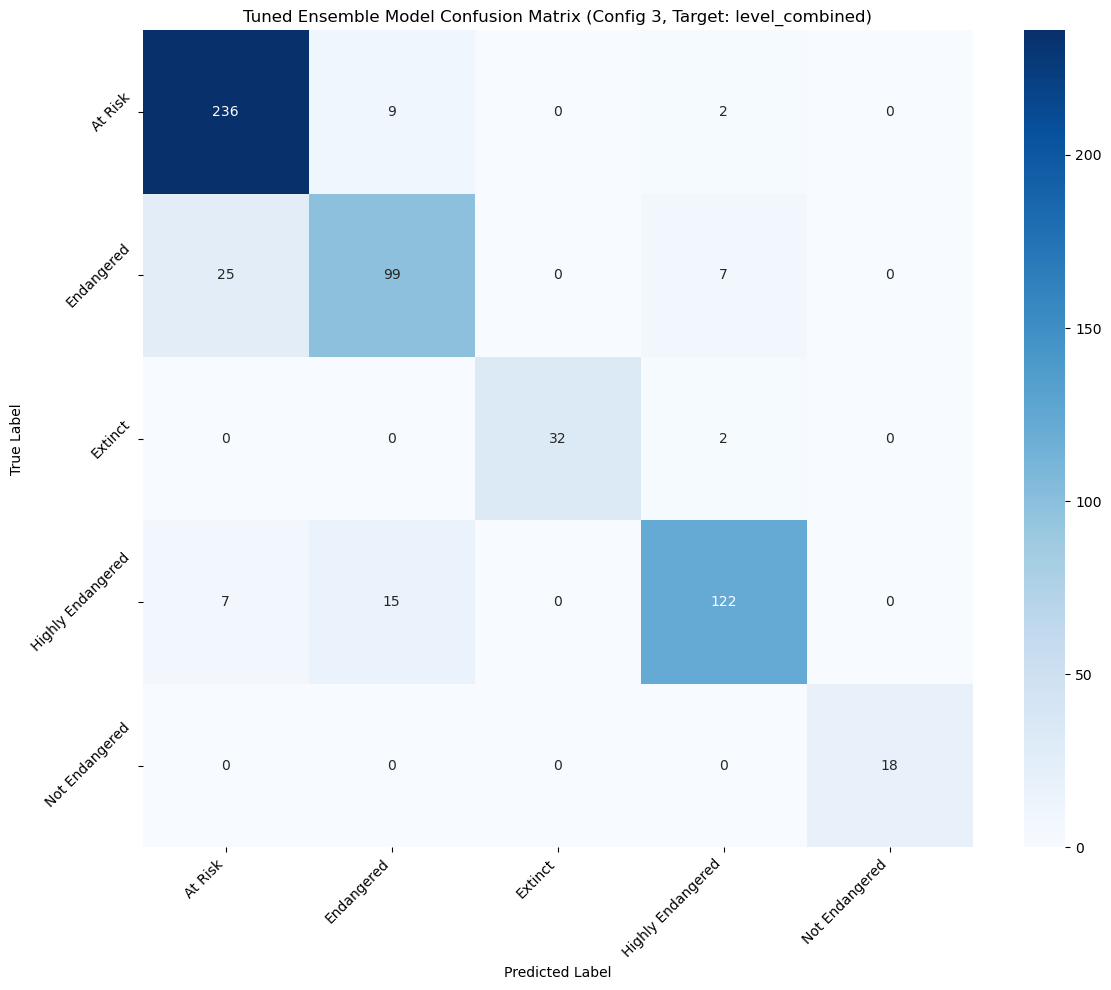

In [33]:
tuned_ensemble_model, scaler, feature_cols, X_train, X_test, y_train_encoded, y_test_encoded = tune_hyperparameters(df_modified, target_column='level_combined')

## Tuning: Ensamble with Bagging method

| Configuration | Features Used | Class Imbalance Handling | Method | Test Accuracy | Precision (Macro Avg) | Recall (Macro Avg) | F1-Score (Macro Avg) | Notes |
|---|---|---|---|---|---|---|---|---|
| Config 1 | Original + Engineered Features | None | Bagging | 75% | 77% | 73% | 74% |  |
| Config 2 | Original + Engineered Features | SMOTE | Bagging | 77% | 78% | 79% | 78% | Improved slightly |
| Config 3 | Original + Engineered Features | Class Weighting | Bagging | 74.9% | 78% | 80% | 77% |  |
| Config 4 | Original + Engineered Features | SMOTETomek | Bagging | 73.2% | 74% | 76% | 74% |  |

### Best Bagging Models

Granular levels
- Training Accuracy: 87.6%
- Validation Accuracy: 74.4%
- Test Accuracy: 77.0%
- *Notes:* ~10% gap between training and test accuracies, minimal improvements compared to base model.

Grouped levels
- Training Accuracy: 94.2%
- Validation Accuracy: 89.4%
- Test Accuracy: 88.5%
- *Notes:* slightly higher test accuracy, ~6% gap between training and test accuracy.


In [34]:
def train_and_evaluate_bagging_model(df_input, target_column='level'):
    """
    Trains and evaluates a Bagging Classifier model with hyperparameter tuning and SMOTE,
    using a specified target column.

    Args:
        df_input (pd.DataFrame): The input dataframe (either original or modified).
        target_column (str): The name of the target column ('level' or 'level_combined').
    """
    print(f"\nTraining and Evaluating Bagging Classifier Model with Tuning and SMOTE (Target: {target_column})...")

    # Re-perform data preparation and splitting to make variables available
    df_feat = prepare_features_with_engineering(df_input)

    feature_cols = list(df_input.columns[4:12]) + [
        'urbanization_internet_product',
        'official_national_sum', 'minority_regional_sum',
        'log_speakers', 'speakers_urbanization', 'speakers_internet'
    ]

    X = df_feat[feature_cols]
    # Use the specified target column as the target variable
    y = df_feat[target_column]

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
        X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )

    # Then split train into train (60) and val (20)
    X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(
        X_train, y_train_encoded, test_size=0.25, stratify=y_train_encoded, random_state=42
    )

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    # Handle class imbalance on the training data before tuning and training the final model using SMOTE
    # Explicitly set k_neighbors for SMOTE based on the smallest class size if needed
    min_samples = min(np.bincount(y_train_encoded))
    n_neighbors_smote = max(1, min(5, min_samples - 1)) # Ensure n_neighbors is at least 1 if possible

    smote = SMOTE(random_state=42, k_neighbors=n_neighbors_smote)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_encoded)


    # Define the base estimator (remove class_weight as we are using resampling)
    base_estimator = DecisionTreeClassifier(random_state=42)

    # Create the Bagging Classifier model for tuning
    bagging_model_to_tune = BaggingClassifier(estimator=base_estimator, random_state=42, n_jobs=-1)


    # Define the parameter grid for Bagging Classifier tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_samples': [0.8, 1.0],
        'max_features': [0.8, 1.0],
        # Tuning max_depth for the base estimator
        'estimator__max_depth': [None, 5, 10]
    }

    # Create GridSearchCV object
    grid_search = GridSearchCV(bagging_model_to_tune, param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)

    # Perform grid search on the balanced training data
    print("Performing Grid Search for Bagging Classifier...")
    grid_search.fit(X_train_balanced, y_train_balanced)

    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation accuracy found: ", grid_search.best_score_)

    # Get the best model
    best_bagging_model = grid_search.best_estimator_

    print("\nTuned Bagging Classifier Model Trained.")

    # Evaluate the best Bagging Classifier model on the original (unbalanced) validation and test sets
    y_train_pred_encoded = best_bagging_model.predict(X_train_balanced) # Predict on balanced training data
    y_val_pred_encoded = best_bagging_model.predict(X_val_scaled)
    y_test_pred_encoded = best_bagging_model.predict(X_test_scaled)

    train_accuracy = accuracy_score(y_train_balanced, y_train_pred_encoded) # Evaluate on balanced training data
    val_accuracy = accuracy_score(y_val_encoded, y_val_pred_encoded)
    test_accuracy = accuracy_score(y_test_encoded, y_test_pred_encoded)

    print(f"\nTraining Accuracy: {train_accuracy:.3f}")
    print(f"Validation Accuracy: {val_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")


    # Decode predictions back to original labels for evaluation
    y_pred_bagging = le.inverse_transform(y_test_pred_encoded)
    y_test = le.inverse_transform(y_test_encoded)


    # Print classification report
    print(f"\nTuned Bagging Classifier Test Classification Report (Target: {target_column}):")
    print(classification_report(y_test, y_pred_bagging))

    # Plot confusion matrix
    cm_bagging = confusion_matrix(y_test, y_pred_bagging)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_bagging, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f'Tuned Bagging Classifier Confusion Matrix with SMOTE (Target: {target_column})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return best_bagging_model, scaler, feature_cols, X_train, X_test, y_train_encoded, y_test_encoded


Training and Evaluating Bagging Classifier Model with Tuning and SMOTE (Target: level)...
Performing Grid Search for Bagging Classifier...
Best parameters found:  {'estimator__max_depth': 10, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 100}
Best cross-validation accuracy found:  0.8421581351381716

Tuned Bagging Classifier Model Trained.

Training Accuracy: 0.876
Validation Accuracy: 0.744
Test Accuracy: 0.770

Tuned Bagging Classifier Test Classification Report (Target: level):
                       precision    recall  f1-score   support

              At risk       0.48      0.77      0.59        13
Critically Endangered       0.91      0.75      0.82        77
           Endangered       0.80      0.79      0.80       131
              Extinct       1.00      0.94      0.97        34
       Not Endangered       0.95      1.00      0.97        18
  Severely Endangered       0.65      0.63      0.64        67
           Threatened       0.74      0.86      0.80       1

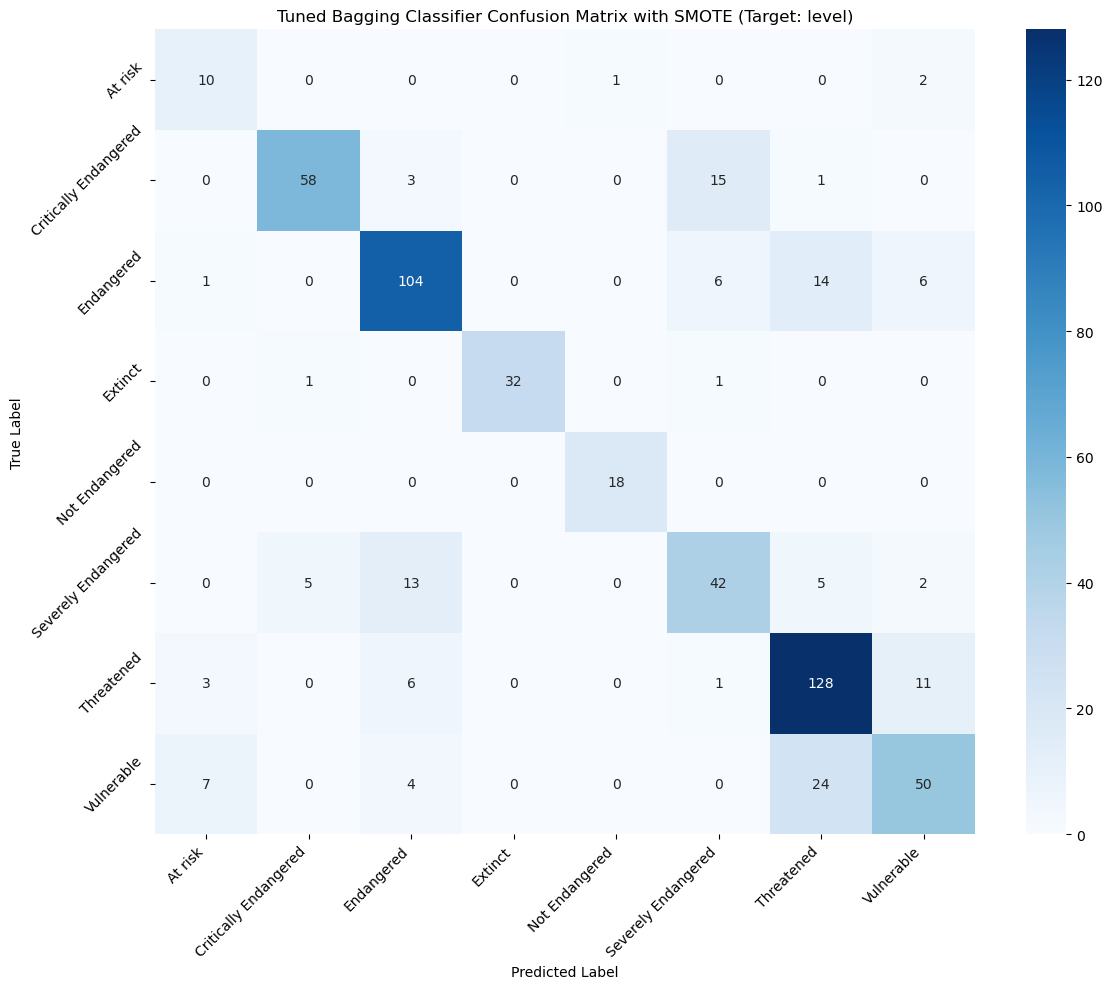

In [35]:
bagging_model, scaler, feature_cols, X_train, X_test, y_train_encoded, y_test_encoded = train_and_evaluate_bagging_model(df, target_column='level')


Training and Evaluating Bagging Classifier Model with Tuning and SMOTE (Target: level_combined)...
Performing Grid Search for Bagging Classifier...
Best parameters found:  {'estimator__max_depth': 10, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 100}
Best cross-validation accuracy found:  0.9070080862533694

Tuned Bagging Classifier Model Trained.

Training Accuracy: 0.942
Validation Accuracy: 0.894
Test Accuracy: 0.885

Tuned Bagging Classifier Test Classification Report (Target: level_combined):
                   precision    recall  f1-score   support

          At Risk       0.89      0.95      0.92       247
       Endangered       0.80      0.77      0.79       131
          Extinct       1.00      0.97      0.99        34
Highly Endangered       0.90      0.85      0.87       144
   Not Endangered       1.00      1.00      1.00        18

         accuracy                           0.89       574
        macro avg       0.92      0.91      0.91       574
     weigh

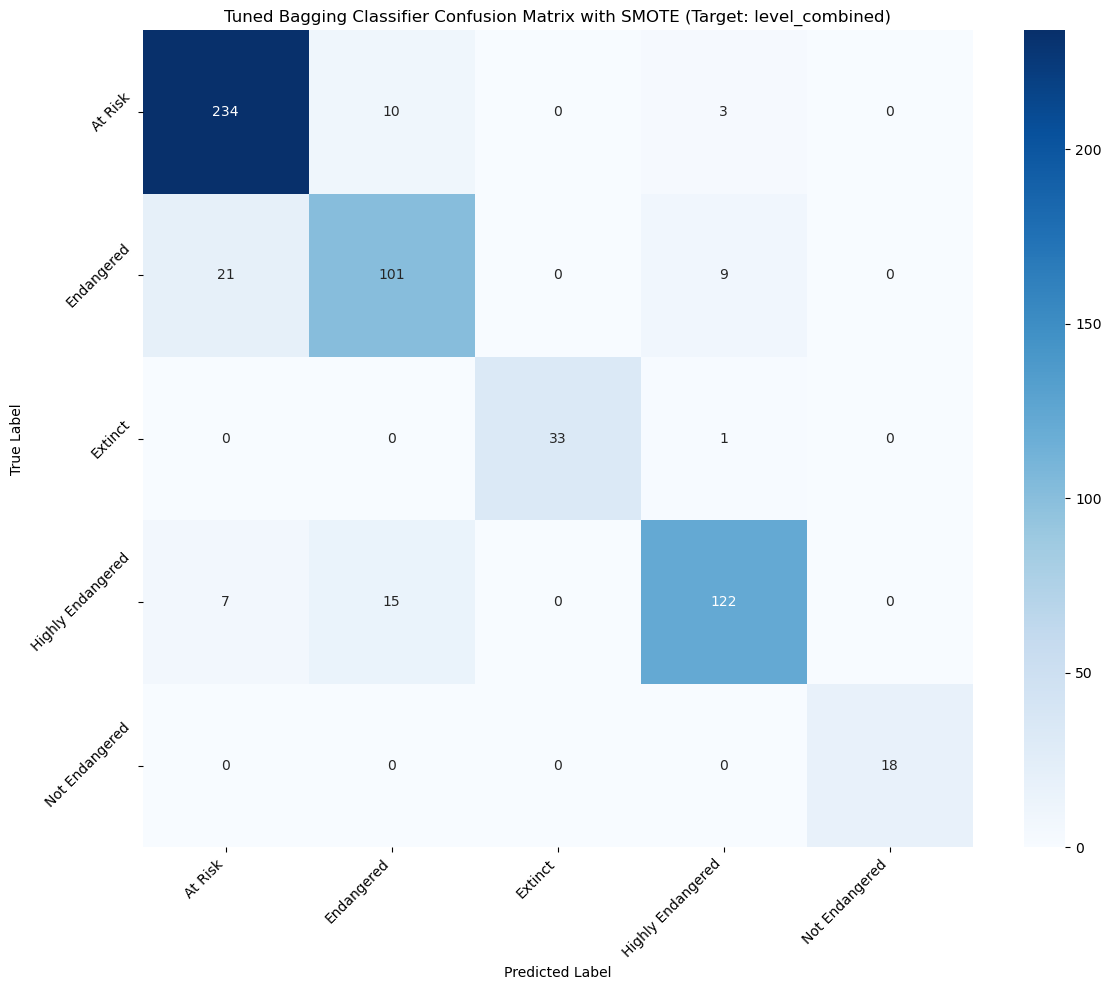

In [36]:
bagging_model_combined, scaler_combined, features_combined, X_train_combined, X_test_combined, y_train_encoded_combined, y_test_encoded_combined = train_and_evaluate_bagging_model(df_modified, target_column='level_combined')

## Feature Importance Analysis

The results of the feature importance analysis show that log_speakers is the most important feature in the model to determine level of endangerment, followed by the interaction terms between speakers and internet use and speakers and urbanization. This suggests that social dynamics and movement are more important to the conservation and preservation of a language than political protections like official, national or regional languages.

ALthough increasing the number of speakers is a more obvious solution to language loss, these results suggest that directing efforts towards increasing speakers in urban areas, as well as increasing the presence of the language online may provide more sustainable results for langauge preservation and vitality.



In [37]:
def plot_feature_importance(model, feature_names, model_name, X_test=None, y_test=None,
                          scaler=None, use_permutation=False):
    """
    Plot feature importance for a given model
    """
    plt.figure(figsize=(10, 8))

    if use_permutation and X_test is not None and y_test is not None:
        # Use permutation importance for models without built-in feature importance
        if scaler is not None:
            X_test_scaled = scaler.transform(X_test)
        else:
            X_test_scaled = X_test

        perm_importance = permutation_importance(model, X_test_scaled, y_test,
                                               n_repeats=10, random_state=42)
        importances = perm_importance.importances_mean
        std_devs = perm_importance.importances_std
    else:
        # Use built-in feature importance
        importances = model.feature_importances_
        std_devs = None

    # Create dataframe for sorting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)

    # Create horizontal bar plot
    bars = plt.barh(importance_df['feature'], importance_df['importance'])

    # Color bars by importance
    colors = plt.cm.viridis(importance_df['importance'] / importance_df['importance'].max())
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    # Add value labels
    for i, (idx, row) in enumerate(importance_df.iterrows()):
        plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}',
                va='center', fontsize=9)

    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'{model_name} - Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print top 10 features
    print(f"\nTop 10 Features for {model_name}:")
    print(importance_df.nlargest(10, 'importance').to_string(index=False))

def plot_feature_importance(ensemble_model, features, X_test, y_test):
    """
    Plot feature importances for all models
    """
    print("=" * 60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)

    # 5. Ensemble
    if ensemble_model is not None:
        # For voting classifier, we'll average the feature importances of tree-based models
        tree_importances = []
        for name, estimator in ensemble_model.named_estimators_.items():
            if hasattr(estimator, 'feature_importances_'):
                tree_importances.append(estimator.feature_importances_)

        if tree_importances:
            avg_importance = np.mean(tree_importances, axis=0)

            plt.figure(figsize=(10, 8))
            importance_df = pd.DataFrame({
                'feature': features,
                'importance': avg_importance
            }).sort_values('importance', ascending=True)

            bars = plt.barh(importance_df['feature'], importance_df['importance'])
            colors = plt.cm.viridis(importance_df['importance'] / importance_df['importance'].max())
            for bar, color in zip(bars, colors):
                bar.set_color(color)

            for i, (idx, row) in enumerate(importance_df.iterrows()):
                plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}',
                        va='center', fontsize=9)

            plt.xlabel('Feature Importance', fontsize=12)
            plt.title('Ensemble Model - Average Feature Importance', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

            print("\nTop 10 Features for Ensemble Model:")
            print(importance_df.tail(10).to_string(index=False))

def analyze_feature_correlations(df, features, top_n=10):
    """
    Analyze correlations between top features
    """
    # Prepare features
    df_feat = prepare_features_with_engineering(df)

    # Get feature data
    feature_data = df_feat[features]

    # Calculate correlation matrix
    corr_matrix = feature_data.corr()

    # Plot correlation heatmap for top features
    plt.figure(figsize=(10, 8))

    # Select top features based on variance
    top_features = feature_data.var().nlargest(top_n).index.tolist()

    sns.heatmap(corr_matrix.loc[top_features, top_features],
                annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1)
    plt.title(f'Feature Correlation Matrix (Top {top_n} by Variance)',
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

FEATURE IMPORTANCE ANALYSIS


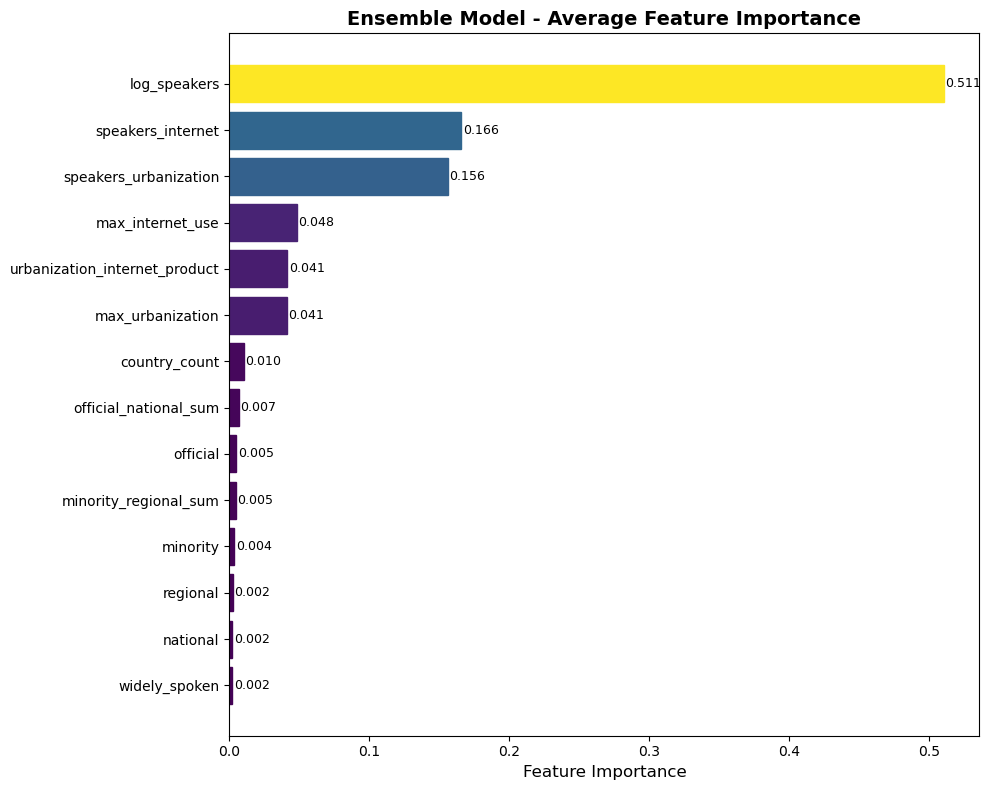


Top 10 Features for Ensemble Model:
                      feature  importance
        minority_regional_sum    0.004526
                     official    0.004941
        official_national_sum    0.006687
                country_count    0.010499
             max_urbanization    0.040972
urbanization_internet_product    0.041336
             max_internet_use    0.047930
        speakers_urbanization    0.156390
            speakers_internet    0.165827
                 log_speakers    0.510676


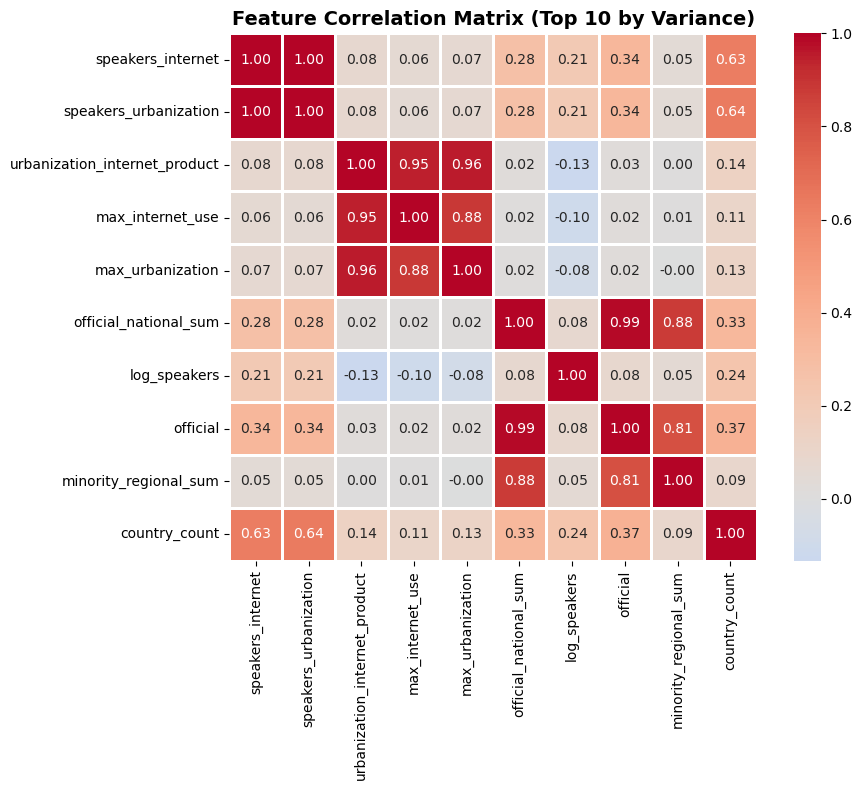

In [39]:
plot_feature_importance(tuned_ensemble_model, features, X_test, y_test)

# Feature correlation analysis:
analyze_feature_correlations(df_modified, features)